In [2]:
%load_ext lab_black

In [42]:
import jax
import jax.numpy as jnp
import jax.random as jr
import objax
import matplotlib.pyplot as plt
from objax import Module, TrainVar
from jax import vmap
from jax.config import config

config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

In [43]:
class MeanFunction(Module):
    def __init__(self, name: str = None):
        self.name = name

    def __call__(self, x: jnp.array) -> jnp.array:
        raise NotImplementedError


class Zero(MeanFunction):
    def __init(self, name="Zero"):
        self.name = name

    def __call__(self, x: jnp.array) -> jnp.array:
        return jnp.zeros_like(x)

In [44]:
class Likelihood(Module):
    def __init__(self, name: str = None):
        self.name = name

    def update(self, params: dict):
        raise NotImplementedError


class Gaussian(Likelihood):
    def __init__(self, observation_noise: float = 1.0, name: str = "Gaussian"):
        super().__init__(name)
        self.noise = TrainVar(jnp.array(observation_noise))

In [45]:
class Kernel(Module):
    def __init__(self, name: str = None):
        self.name = name

    def fun(self, x: jnp.array, y: jnp.array) -> jnp.array:
        raise NotImplementedError

    def __call__(self, x: jnp.array, y: jnp.array, jitter: float = 1e-6) -> jnp.array:
        raise NotImplementedError


class Stationary(Kernel):
    def __init__(self, name="Stationary"):
        super().__init__(name=name)

    def __call__(self, x: jnp.array, y: jnp.array, jitter: float = 1e-6) -> jnp.array:
        K = vmap(lambda x1: vmap(lambda y1: self.fun(x1, y1))(y))(x)
        if x.shape[0] == y.shape[0]:
            jitter_mat = jnp.eye(x.shape[0]) * jitter
            K += jitter_mat
        return K


class RBF(Stationary):
    def __init__(
        self, lengthscale: float = 1.0, variance: float = 1.0, name: str = "RBF"
    ):
        super().__init__(name)
        self.lengthscale = TrainVar(jnp.ones(1))
        self.variance = TrainVar(jnp.ones(1))

    def fun(self, x: jnp.array, y: jnp.array) -> jnp.array:
        tau = jnp.square(x - y)
        Phi = jnp.square(self.variance.value) * jnp.exp(
            -tau / (2 * jnp.square(self.lengthscale.value))
        )
        return Phi.reshape()

In [46]:
class Prior(Module):
    def __init__(
        self, kernel: Kernel, mean_function: MeanFunction = Zero, name: str = "Prior"
    ):
        super().__init__()
        self.meanf = mean_function
        self.kernel = kernel
        self.name = name

    def __mul__(self, other: Likelihood):
        return Posterior(self, other)


class Posterior(Module):
    def __init__(self, prior: Prior, likelihood: Gaussian, name: str = "Posterior"):
        super().__init__()
        self.likelihood = likelihood
        self.kernel = prior.kernel
        self.meanf = prior.meanf

    def marginal_log_likelihood(self, X: jnp.array, y: jnp.array):
        N = X.shape[0]
        Kff = self.kernel(X, X) + jnp.eye(N) * self.likelihood.noise.value
        L = jnp.linalg.cholesky(Kff)
        diag_sum = jnp.sum(jnp.log(jnp.diag(L)))
        alpha = jnp.linalg.lstsq(L.T, jnp.linalg.lstsq(y.reshape(-1, 1), L)[0].T)[0]
        obj = diag_sum + (0.5 * jnp.dot(y.T, alpha)) + (0.5 * N * jnp.log(2 * jnp.pi))
        print(obj)
        return obj.reshape()

In [47]:
meanf = Zero()
kernel = RBF()
f = Prior(kernel, meanf)

lik = Gaussian()
posterior = f * lik

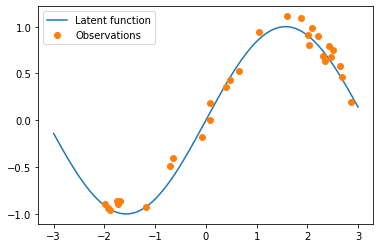

In [48]:
n = 30
x = jr.uniform(key, shape=(n,), minval=-3.0, maxval=3.0).sort()
f = lambda x: jnp.sin(x)
signal = f(x)
noise = jr.normal(key, signal.shape) * 0.1
y = signal + noise

xtest = jnp.linspace(-3.0, 3.0, 500)
ytest = f(xtest)

plt.plot(xtest, ytest, label="Latent function")
plt.plot(x, y, "o", label="Observations")
plt.legend(loc="best")

In [49]:
posterior.marginal_log_likelihood(x, y)

[32.30057122]


DeviceArray(32.30057122, dtype=float64)

In [50]:
gradfun = objax.GradValues(posterior.marginal_log_likelihood, posterior.vars())

In [51]:
gradfun(x, y)

Traced<ConcreteArray([32.30057122])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([32.30057122], dtype=float64)
       tangent = Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)>


FloatingPointError: invalid value (nan) encountered in dot_general

In [39]:
g = objax.GradValues(kernel.fun, kernel.vars())

In [41]:
g(2.0, 3.0)

([DeviceArray([0.60653066], dtype=float64),
  DeviceArray([1.21306132], dtype=float64)],
 [DeviceArray(0.60653066, dtype=float64)])